# Linear regression with Professor Mittens, a.k.a. recipe for linear regression.

## Overview

In this notebook we will learn how to use regression to study the factors that affect the number of pats cats will recieve. This will start with a visual inspection of the data, followed by the development of a linear model to explain the data. Along the way we will answer a few questions such as: does coat colour influence the number of pats, is a long coat better than a short coat, and how important is the volume of a meow.

## Specifying regression models

A very popular way to describe regression models is with "formulae" as popularised by R. The [R documentation on formulae](https://cran.r-project.org/doc/manuals/R-intro.html#Formulae-for-statistical-models) is a good place to learn how to use these properly. For example, here is the syntax we will use today,

- `y ~ x1 + x2` will make a linear model with the predictors $x_1$ and $x_2$.
- `y ~ x1 * x2` includes the terms $x_1 + x_2 + x_1x_2$
- `y ~ x1 : x2` includes *just* the interaction term $x_1x_2$
- `y ~ C(x)` specifies that $x$ is a catagorical variable **NOTE** this is not necessary in R.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import altair as alt
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sns.set_theme(style="whitegrid")

## Helping cats get more pats

Professor Mittens in interested in helping cats optimise the number of pats they can get. To learn more about this, he has interviewed 1000 cats and taken measurements of their behaviour and appearance. The data in `cat-pats.csv` contains measurments of the following:

- `time_outdoors` is the number of hours that the cat is out of their primary dwelling,
- `coat_colour` is either tortoiseshell, white, or "other" encoded as integers 1, 2, and 3 respectively,
- `weight` is the weight of the cat in kilograms,
- `height` is their height in centimeters,
- `loudness` is a measure of how loud their meow is, the units are not known,
- `whisker_length` is the length of their whiskers in centimeters,
- `is_longhaired` is a Boolean variable equal to 1 if the cat is of a longhaired breed and 0 if it is of a shorthaired breed,
- `coat_length` is the length of their fur in centimeters,
- and `num_pats` is the number of pats they received on the day they were interviewed.

The variable we are interested in explaining is `num_pats`. Although this is a discrete variable, we will ignore this aspect of the data and consider it as a continuous value. This is a useful simplifying assumption, as you learn more about regression, in particular generalized linear models, you will see additional ways to handle this. For this example, you can consider it a continuous variable though.

The types of questions that Professor Mittens is interested in answering are as follows:

1. Do any of the variables correlate with the number of pats that the cats recieve?
2. Under a naive model, how much of the variability in pats can they explain? Do all the variables need to be included?
3. Does the coat colour matter?
4. Among short-haired breeds they say longer hair is better, among long-haired breeds they say short hair is better, who is correct?
5. **If a cat can choose to spend more time outdoors, or practise meowing louder, which will get them more pats?**

### Read in the data and generate some scatter plots to see if there are any good predictors of the number of pats

The data is in the file `cat-pats.csv` so read this into a data frame using `pd.read_csv` and go from there. I have used altair to generate my scatter plots based on [this example](https://altair-viz.github.io/gallery/scatter_matrix.html) but you can use whatever you feel most comfortable with. It might be useful to use colour to see if `coat_colour` and `is_longhaired` are important. 


In [5]:
df = pd.read_csv('cat-pats.csv')
df.head()

,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length,num_pats
0,7.968883,3,3.474459,24.679895,2.776442,8.350615,1,6.306728,38
1,12.481158,3,3.476376,25.236722,3.263675,8.182506,0,3.059234,52
2,2.229639,3,3.934887,23.551737,2.215878,7.673753,1,7.667451,32
3,10.978511,1,3.802978,24.247849,4.799470,8.689976,1,7.169723,48
4,8.674765,3,4.234895,24.425628,2.496709,8.073498,0,5.605462,50


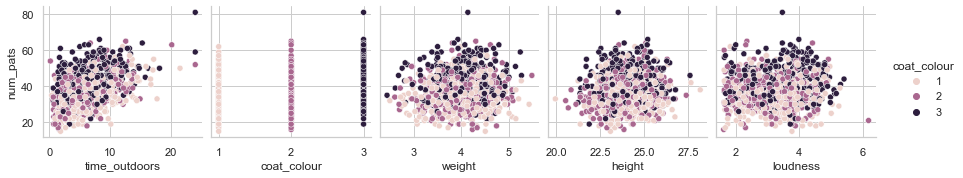

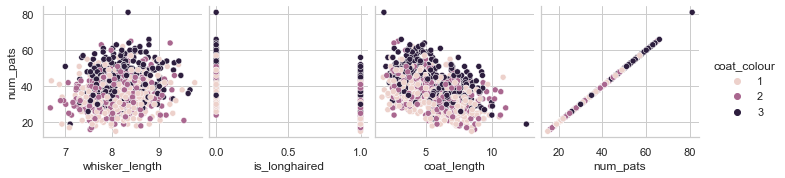

In [6]:
sns.pairplot(df, y_vars = 'num_pats', x_vars = df.columns[:5], hue = 'coat_colour', diag_kind = None)
sns.pairplot(df, y_vars = 'num_pats', x_vars = df.columns[5:], hue = 'coat_colour', diag_kind = None)
plt.show()

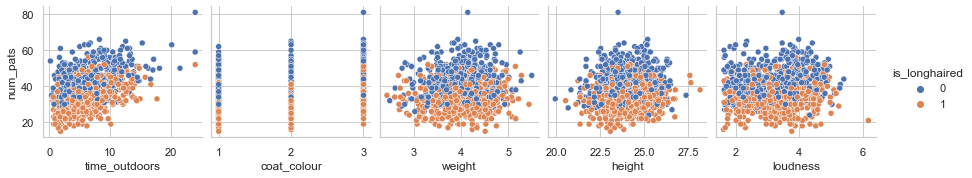

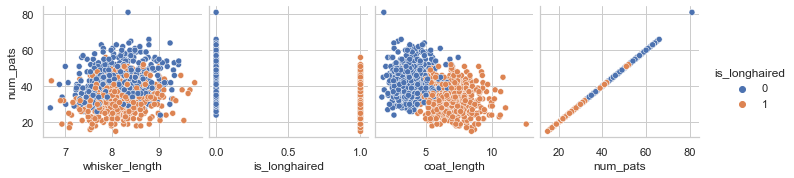

In [7]:
sns.pairplot(df, y_vars = 'num_pats', x_vars = df.columns[:5], hue = 'is_longhaired', diag_kind = None)
sns.pairplot(df, y_vars = 'num_pats', x_vars = df.columns[5:], hue = 'is_longhaired', diag_kind = None)
plt.show()

### Question

Based on these figures, what variables appear to relate to the number of pats? What do you notice about the catagorical variables `coat_colour` and `is_longhaired`?

`time_outdoors` and `coat_length` seem to be the continuous variables that relate to number of pats the most. In the former case, we can see a positive relationship, while in the latter case a negative one. Also, there is a clear difference in the number of pats between long and short haired cats. Thus, we need to account for the effect of this quantitative variable on the dependent variable  

### Compute the correlation between each variable and the number of pats, what looks important

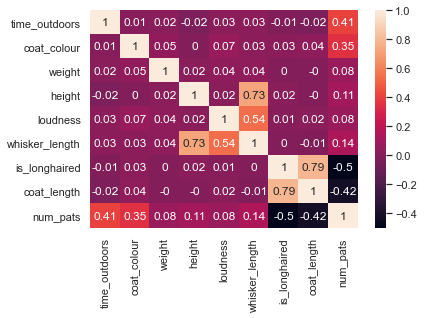

In [8]:
corrMatrix = round(df.corr(), 2)
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Question

Does the the correlation matrix raise any further questions? Does it handle the catagorical variables correctly?

### What is $R^2$?

Sometimes called the *coefficient of determination*, this statistic measures the proportion of the variance in the response variable that is explained by the regression model. In the case of simple linear regression it is just the correlation squared, it can also be calculated as the ratio of the regression sum of squares and the total sum of squares. 

$$
R^2 = \frac{\text{RegSS}}{\text{TSS}}
$$

It can be thought of as the proportion of the total variance that is explained by the regression model.

### What is an *adjusted* $R^2$?

For a fixed number of observations, as the number of covariates increases you can get explain as much of the variability as you want! The adjusted $R^2$ is a way to penalise using too many covariates. The adjusted $R^2$ for a model with $n$ observations and $p$ coefficients is given by the following:

$$
\tilde{R}^2 = 1 - \frac{n - 1}{n - p}\left(1 - R^2\right)
$$

### Under a naive model, how much of the variability in pats can they explain?

Run an ordinary linear regression with all of the variables and see what percentage of the variability in the number of pats is explained. Make sure that you have used the catagorical variables correctly. Can be be confident in rejecting the null hypothesis that none of these variables is associated with the number of pats received?

In [9]:
df.head()

,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length,num_pats
0,7.968883,3,3.474459,24.679895,2.776442,8.350615,1,6.306728,38
1,12.481158,3,3.476376,25.236722,3.263675,8.182506,0,3.059234,52
2,2.229639,3,3.934887,23.551737,2.215878,7.673753,1,7.667451,32
3,10.978511,1,3.802978,24.247849,4.799470,8.689976,1,7.169723,48
4,8.674765,3,4.234895,24.425628,2.496709,8.073498,0,5.605462,50


In [10]:
results = smf.ols('num_pats ~ time_outdoors + C(coat_colour) + weight + height + whisker_length +\
                  C(is_longhaired) + coat_length', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     164.7
Date:                Thu, 12 Nov 2020   Prob (F-statistic):          3.79e-176
Time:                        14:31:10   Log-Likelihood:                -3240.2
No. Observations:                1000   AIC:                             6498.
Df Residuals:                     991   BIC:                             6543.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.73

### Question: Is colinearity an issue in this model? Do all of the variables need to be included?

Compute the VIF to see if there is a concerning amount of colinearity between any of the covariates.

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(df.iloc[:, :-1])
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const             534.769517
time_outdoors       1.007960
coat_colour         1.009396
weight              1.004586
height              3.925269
loudness            2.584257
whisker_length      5.567433
is_longhaired       2.647906
coat_length         2.649439
dtype: float64

In [13]:
X = add_constant(df.iloc[:, :-1])
X

,const,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length
0,1.0,7.968883,3,3.474459,24.679895,2.776442,8.350615,1,6.306728
1,1.0,12.481158,3,3.476376,25.236722,3.263675,8.182506,0,3.059234
2,1.0,2.229639,3,3.934887,23.551737,2.215878,7.673753,1,7.667451
3,1.0,10.978511,1,3.802978,24.247849,4.799470,8.689976,1,7.169723
4,1.0,8.674765,3,4.234895,24.425628,2.496709,8.073498,0,5.605462
...,...,...,...,...,...,...,...,...,...
995,1.0,12.198816,2,3.884863,22.834104,3.752737,7.650264,1,7.519727
996,1.0,2.519829,3,4.694109,23.331903,2.889438,7.595348,0,3.709409
997,1.0,6.380990,2,4.184664,24.907993,3.289389,8.040561,1,6.511048
998,1.0,2.484029,1,3.705406,22.562536,3.567503,7.722303,0,3.792457


In [85]:
#remove whisker length
results = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + C(is_longhaired) + coat_length", df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     164.7
Date:                Sun, 08 Nov 2020   Prob (F-statistic):          3.82e-176
Time:                        17:38:56   Log-Likelihood:                -3240.3
No. Observations:                1000   AIC:                             6499.
Df Residuals:                     991   BIC:                             6543.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.52

### Does coat colour matter?

1. Make a box plot of the number of pats by coat colour to see this pattern.
2. Fit an additional linear model without the coat colour as a covariate to see how much of the explained variability comes from the inclusion of coat colour in the model.

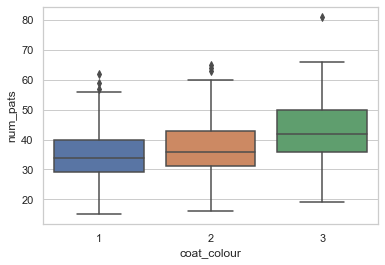

In [86]:
sns.boxplot(y = 'num_pats', x = 'coat_colour', data = df)
plt.show()

In [87]:
results_with = smf.ols('num_pats ~ time_outdoors + coat_colour + weight + height +\
                  C(is_longhaired) + coat_length', data=df).fit()
results_wo = smf.ols('num_pats ~ time_outdoors + weight + height +\
                  C(is_longhaired) + coat_length', data=df).fit()

In [88]:
#ask why it does't work with r squared
print(results_with.rsquared_adj - results_wo.rsquared_adj) 

0.13128489045882263


### Among short-haired breeds they say longer hair is better, among long-haired breeds they say short hair is better, who is correct?

Since in the figures above we saw that the breed longhaired/shorthaired appears to separate the data, it may be useful to consider different models on each subset. Fit a linear model to each subset of the data and see that the effect of the coat length is in each case.

In [89]:
results = smf.ols('num_pats ~ time_outdoors + C(coat_colour) + weight + height +\
                  + C(is_longhaired) + coat_length', data=df[df['is_longhaired'] == 0]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     64.95
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           1.77e-59
Time:                        17:38:57   Log-Likelihood:                -1662.5
No. Observations:                 506   AIC:                             3339.
Df Residuals:                     499   BIC:                             3369.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.4010    

In [90]:
results = smf.ols('num_pats ~ time_outdoors + C(coat_colour) + weight + height +\
                  C(is_longhaired) + coat_length', data=df[df['is_longhaired'] == 1]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     64.80
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           5.19e-59
Time:                        17:38:57   Log-Likelihood:                -1564.0
No. Observations:                 494   AIC:                             3142.
Df Residuals:                     487   BIC:                             3171.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6148    

### Fit a model with *only* the interacion term between the coat length and "is longhaired" and the other covariates

What does this tell us about the age old debate about cat hair length? Why are we ignoring the [Principle of Marginality](https://en.wikipedia.org/wiki/Principle_of_marginality) in this example?

In [91]:
results = smf.ols('num_pats ~ time_outdoors + C(coat_colour) + weight + height +\
                  + C(is_longhaired):coat_length', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     194.0
Date:                Sun, 08 Nov 2020   Prob (F-statistic):          6.74e-181
Time:                        17:38:57   Log-Likelihood:                -3231.9
No. Observations:                1000   AIC:                             6480.
Df Residuals:                     992   BIC:                             6519.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

### How else could we handle coat length?

We could instead have included quadratic terms for coat length to see if this was a better way to explain the non-linear effect.

### Shouldn't we check for influential points?

We can generate a plot of the studentized residuals and the leverage to check if there are any influential points.

If there is a potential outlier, does removing it change anything?

### Should a cat practise meowing or just spend more time outdoors to get more pats?

We can just look at the coefficients to see that a much more efficient way to get pats is to be outside, the relationship between loudness and number of pats is not supported by this data set.